In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

%matplotlib inline
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize

from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [117]:
%%time
data = pd.read_csv('DATA/16-18pivot_prep.csv')
data.drop(['Unnamed: 0'], axis=1,inplace = True)
data = data.dropna()#drop fired stuff to compensate disproportion of classes


Wall time: 23.2 s


In [118]:
data.head(3)

,ACC,LVL_0,LVL_1,LVL_2,LVL_3,LVL_4,LVL_5,LVL_6,LVL_7,LVL_8,...,DL_T19_35,DL_T19_36,DL_T19_37,DL_T19_38,DL_T19_39,DL_T19_40,DL_T19_41,DL_T19_42,DL_T19_43,DL_T19_44
0,C0100006,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C0100052,3.0,3.0,3.0,1.0,1.0,3.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,C0100074,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
#save numbers of stuff existed in 44 camp to 
acc_numbers = data[['ACC']]
acc_numbers.info()
data.drop(['ACC'], axis=1,inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12910 entries, 0 to 131078
Data columns (total 1 columns):
ACC    12910 non-null object
dtypes: object(1)
memory usage: 201.7+ KB


In [120]:
a = [1,2,3,4,5]

In [121]:
a[:3]

[1, 2, 3]

In [122]:
columns_to_norm = [c for c in data.columns if c.upper()[:3] != 'LVL'] #exclude first camp to match size 
lvl_columns = [c for c in data.columns if c.upper()[:3] == 'LVL'] #exclude first camp to match size 

In [123]:
norm_data = pd.DataFrame(normalize(data[columns_to_norm], axis=0))
norm_data.columns = columns_to_norm

In [127]:
data = data[lvl_columns].join(norm_data)

In [41]:
#data = data.assign(ACC=(data['ACC']).astype('category').cat.codes)# convert numbers to index

In [128]:
def plot_difference(df1, df2, camp):
    
    grouped = df1.groupby(df1).count()
    grouped2 = df2.groupby(df2).count()
    result = pd.DataFrame(grouped)
    result2 = pd.DataFrame(grouped2)
    
    result.columns = ['count']
    result['lvl'] = result.index
    result['values'] = 'actual'
    
    result2.columns = ['count']
    result2['lvl'] = result2.index
    result2['values'] = 'prediction'
    
    result_r = pd.concat([result, result2])
    
    import seaborn as sns
    sns.set(style="whitegrid")


    # Draw a nested barplot to show survival for class and sex
    g = sns.catplot(x="lvl", y="count", hue="values", data=result_r,
                height=8, kind="bar", palette="muted",  aspect=1.8)
    g.despine(left=True)
    g.set_ylabels(camp)
    
    return 

In [129]:
data2 = data.copy()

#exclude colums with camp44 data to fit  

Y_44 = data2['LVL_44']
cols = [c for c in data2.columns if c.lower()[-2:] != '44']
data2 = data2[cols]

Y_43 = data2['LVL_43']
cols = [c for c in data2.columns if c.lower()[-2:] != '43']
data2 = data2[cols]

fited_columns = data2.columns # save columns names for inference



In [130]:

%%time
import xgboost as xgb
#train = data2[data2['CAMP'] <= 44]

#xtr = train.drop(['LVL'], axis=1)
#ytr = train['LVL'].values
params = {'n_estimators': 1000,
          'learning_rate': 0.01,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8}

clf_xgb = xgb.XGBClassifier(**params)


clf_xgb.fit(data2, Y_43)



Wall time: 11min 16s


CAMP 1 - Accuracy 0.66026
Wall time: 5.41 s


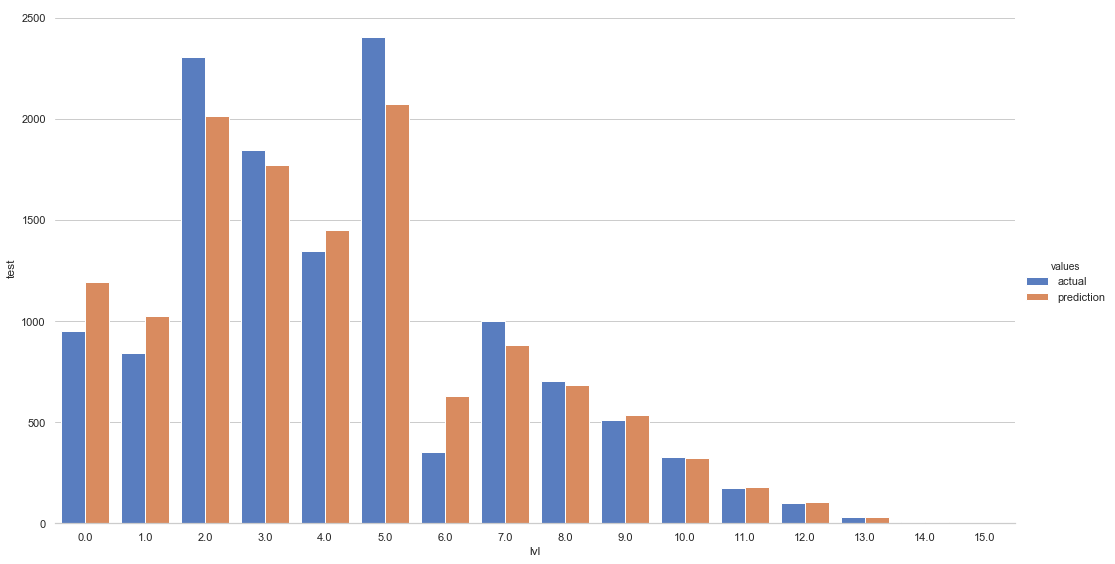

In [131]:
%%time
mean_error = []
p = clf_xgb.predict(data2)
predict = pd.Series(p)

plot_difference(predict, Y_43, 'test')
error = accuracy_score(Y_43, p)
print('CAMP %d - Accuracy %.5f' % (1, error))
mean_error.append(error)

In [132]:
data2 = data.copy()

#data for inference must be same size and has same names 
cols = [c for c in data2.columns if c.lower()[-2:] != '_0'] #exclude first camp to match size 
data2 = data2[cols]

cols = [c for c in data2.columns if c.lower()[-2:] != '44']
data2 = data2[cols]

data2.columns = fited_columns


CAMP 1 - Accuracy 0.46259
Wall time: 4.3 s


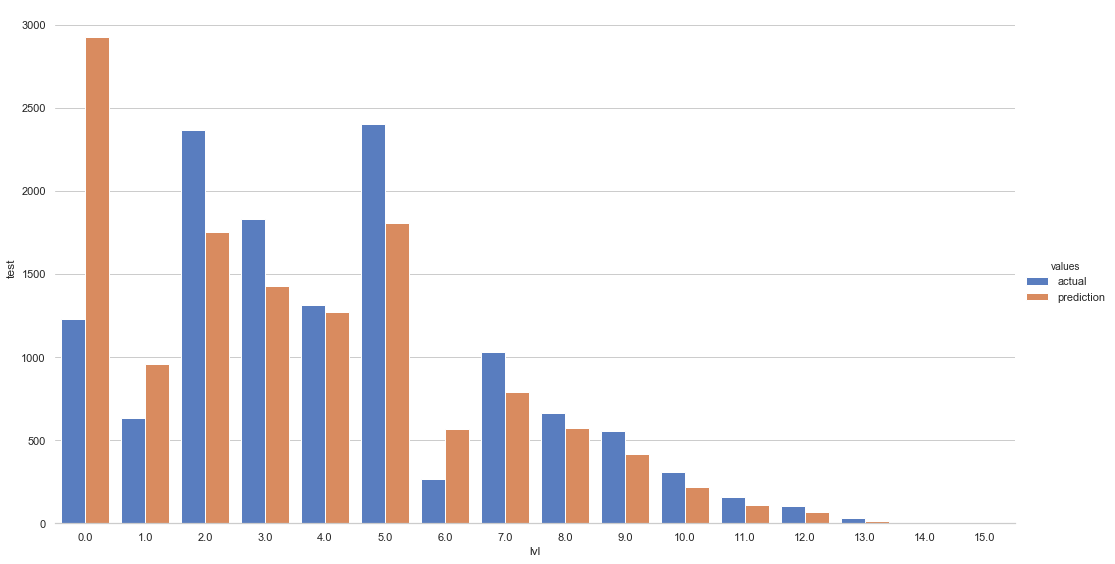

In [133]:
%%time
mean_error = []
p = clf_xgb.predict(data2)
predict = pd.Series(p)

plot_difference(predict, Y_44, 'test')
error = accuracy_score(Y_44, p)
print('CAMP %d - Accuracy %.5f' % (1, error))
mean_error.append(error)

In [12]:
refined = data[['LVL_44']]
refined['predict'] = predict
refined['ACC_N'] = acc_numbers['ACC']
refined.info()

NameError: name 'predict' is not defined

In [ ]:
refined.head(5)

In [ ]:
%%time

refined.to_csv('DATA/predict13.csv', encoding='utf-8')

In [ ]:
'''    grouped = refined['LVL_44'].groupby(refined['LVL_44']).count()
    #grouped2 = refined['LVL_43'].groupby(refined['LVL_43']).count()
    grouped3 = refined['predict'].groupby(refined['predict']).count()
    
    result = pd.DataFrame(grouped)
    #result2 = pd.DataFrame(grouped2)
    result3 = pd.DataFrame(grouped3)
    
    result.columns = ['count']
    result['lvl'] = result.index
    result['values'] = 'actual'
    
 result2.columns = ['count']
    result2['lvl'] = result2.index
    result2['values'] = 'previous'
    
    result3.columns = ['count']
    result3['lvl'] = result3.index
    result3['values'] = 'prediction'
    
    result_r = pd.concat([result, result3]) #, result3])
    
    import seaborn as sns
    sns.set(style="whitegrid")


    g = sns.catplot(x="lvl", y="count", hue="values", data=result_r,
                height=8, kind="bar", palette="muted",  aspect=1.8)
    g.despine(left=True)
    #g.set_ylabels(camp)
    '''

In [ ]:
'''bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)'''

In [ ]:
'''%%time
mean_error = []
df_mean = pd.DataFrame(columns=['LVL_mean'])
for camp in range(34,44):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    p = val['prev_level'].values

    error = rmsle(val['LVL'].values, p)
    plot_difference(val['prev_level'], val['LVL'], camp)
    print('CAMP %d - Accuracy %.5f' % (camp, error))
    mean_error.append(error)

print('Mean Accuracy = %.5f' % np.mean(mean_error))'''

In [ ]:
'''train = data2[data2['CAMP'] <= 44]

xtr = train.drop(['LVL'], axis=1)
ytr = train['LVL'].values

mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
mdl.fit(xtr, ytr)

p = mdl.predict(xts)
p = np.rint(p)
predict = pd.Series(p)
plot_difference(predict, val['LVL'], camp)
error = rmsle(yts, p)
print('CAMP %d - Accuracy %.5f' % (camp, error))
mean_error.append(error)'''